### Online retail Transactional Data

**Overview**<br>
<a href="https://archive.ics.uci.edu/ml/datasets/online+retail">Online retail is a transnational data set</a> which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

The steps are broadly:
1. Read and understand the data
2. Clean the data
3. Prepare the data for modeling
4. Modeling
5. Analysis and Business Recommendation

### 1. Read and understand the data

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [70]:
# read the dataset
retail_df = pd.read_csv('Online_Retail.csv', encoding='ISO-8859-1')
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [71]:
# shape of the dataframe
retail_df.shape

(541909, 8)

In [72]:
# bascis of data
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


### 2. Clean the Data

In [73]:
# Missing data count column wise
round(retail_df.isnull().sum()/retail_df.shape[0]*100, 2)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

We can't drop CustomerID as this is main focus of our problem. So, we will drop the rows that does not have CustomerID.

In [74]:
# Droping rows having missing CustomerID
retail_df = retail_df[~np.isnan(retail_df.CustomerID)]
retail_df.shape

(406829, 8)

### 3. Preparation of Data for modelling

- R (Recency): Number of days since last purchase
- F (Frequency): Number of tracsactions
- M (Monetary): Total amount of transactions (revenue contributed)

In [75]:
# creating new column amount
retail_df["Amount"] = retail_df["Quantity"] * retail_df["UnitPrice"]
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


In [76]:
# creating monetary column
grouped_df = retail_df.groupby('CustomerID')["Amount"].sum()
grouped_df = grouped_df.reset_index()
grouped_df.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [77]:
# creating frequency column
frequency = retail_df.groupby("CustomerID")["InvoiceNo"].count()
frequency = frequency.reset_index()
frequency.columns= ['CustomerID', 'Frequency']
frequency.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [78]:
# merging frequency to group_df
grouped_df = pd.merge(grouped_df, frequency, on = 'CustomerID', how = 'inner')
grouped_df.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [79]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


In [80]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
 8   Amount       406829 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 31.0+ MB


In [81]:
retail_df.InvoiceDate = pd.to_datetime(retail_df.InvoiceDate, format='%d-%m-%Y %H:%M')

In [82]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
 8   Amount       406829 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 31.0+ MB


In [83]:
# compute the max date
max_date = max(retail_df.InvoiceDate)
max_date

Timestamp('2011-12-09 12:50:00')

In [84]:
# compute the Diff col. which is difference between max_date and actual transaction date
retail_df['Diff'] = max_date - retail_df.InvoiceDate
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [85]:
# creating receny col
last_purchase = retail_df.groupby("CustomerID")['Diff'].min()
last_purchase = last_purchase.reset_index()
last_purchase

,CustomerID,Diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00
...,...,...
4367,18280.0,277 days 02:58:00
4368,18281.0,180 days 01:57:00
4369,18282.0,7 days 01:07:00
4370,18283.0,3 days 00:48:00


In [86]:
# merging last_purchase to grouped_df
grouped_df = pd.merge(grouped_df, last_purchase, on='CustomerID', how = 'inner')
grouped_df.columns = ['CustomerID','Amount','Frequency','Recency']
grouped_df.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00


In [87]:
# Convert Recency to Days
grouped_df.Recency = grouped_df.Recency.dt.days
grouped_df.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


- Other preprocessing required:
    1. Outlier treatment
    2. Rescaling

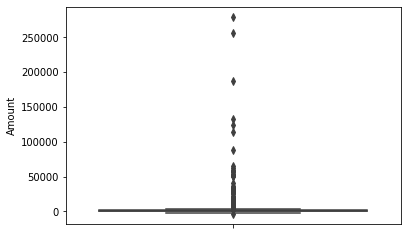

In [88]:
# Outlier treatment
sns.boxplot(data=grouped_df, y ='Amount')

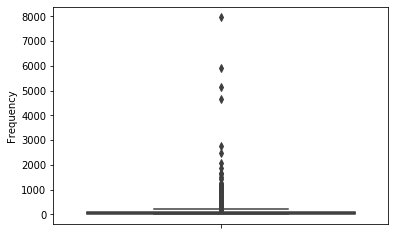

In [89]:
sns.boxplot(data=grouped_df, y ='Frequency')

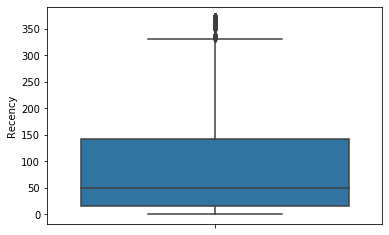

In [90]:
sns.boxplot(data=grouped_df, y ='Recency')

In [91]:
# Removing statistical outliers (Amount)
Q1=grouped_df.Amount.quantile(0.05)
Q3=grouped_df.Amount.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.Amount >= Q1-1.5*IQR) & (grouped_df.Amount <= Q3+1.5*IQR)]

# Removing statistical outliers (Recency)
Q1=grouped_df.Recency.quantile(0.05)
Q3=grouped_df.Recency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.Recency >= Q1-1.5*IQR) & (grouped_df.Recency <= Q3+1.5*IQR)]

# Removing statistical outliers (Frequency)
Q1=grouped_df.Frequency.quantile(0.05)
Q3=grouped_df.Frequency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.Frequency >= Q1-1.5*IQR) & (grouped_df.Frequency <= Q3+1.5*IQR)]


In [92]:
# Rescaling
rfm_df = grouped_df.drop('CustomerID', axis=1)
rfm_df.head()

,Amount,Frequency,Recency
0,0.00,2,325
1,4310.00,182,1
2,1797.24,31,74
3,1757.55,73,18
4,334.40,17,309


In [93]:
rfm_df.columns

Index(['Amount', 'Frequency', 'Recency'], dtype='object')

In [94]:
# scaling the rfm_df
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled

array([[-0.72373821, -0.75288754,  2.30161144],
       [ 1.73161722,  1.04246665, -0.90646561],
       [ 0.30012791, -0.46363604, -0.18365813],
       ...,
       [-0.67769602, -0.70301659,  0.86589794],
       [-0.6231313 , -0.64317145, -0.84705678],
       [ 0.32293822, -0.07464263, -0.50050524]])

In [95]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


In [96]:
# Hopkins Test
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [97]:
#Use the Hopkins Statistic function by passing the above dataframe as a paramter
hopkins(rfm_df_scaled)

0.9561602444958031

### 4. Modelling

In [98]:
# clustering with random value of K
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [99]:
rfm_df_scaled.shape

(4293, 3)

In [100]:
len(kmeans.labels_)

4293

In [101]:
kmeans.labels_

array([3, 2, 0, ..., 3, 0, 0])

#### Finding the Optimal number of cluster

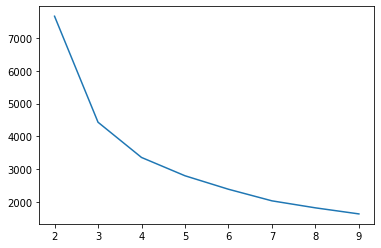

In [102]:
# elbow curve/SSD
ssd=[]
clusters = list(range(2,10))
for cluster in clusters:
    kmeans = KMeans(n_clusters=cluster, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    ssd.append(kmeans.inertia_)

# plot ssd for each cluster number
plt.plot(clusters, ssd)

### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

For n_cluster=2, the silhouette score is 0.5415858652525395.
For n_cluster=3, the silhouette score is 0.5084896296141937.
For n_cluster=4, the silhouette score is 0.477782010021685.
For n_cluster=5, the silhouette score is 0.46413788559626845.
For n_cluster=6, the silhouette score is 0.4170127516626443.
For n_cluster=7, the silhouette score is 0.41790389789539567.
For n_cluster=8, the silhouette score is 0.4016898571826163.
For n_cluster=9, the silhouette score is 0.41528922827702824.


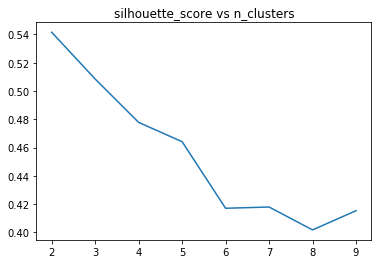

In [113]:
# computing silhouette score
silhouette_scores=[]
for cluster in clusters:
    kmeans = KMeans(n_clusters=cluster, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_cluster={cluster}, the silhouette score is {silhouette_avg}.")

# plotting silhouette_scores
plt.title('silhouette_score vs n_clusters')
plt.plot(clusters, silhouette_scores)

- k = 3 looks decent by both elbow and silhouette score. So, we will proceed with k=3 now.

In [108]:
# proceeding with k=3 clusters
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [109]:
kmeans.labels_

array([2, 0, 1, ..., 2, 1, 1])

In [110]:
# assigning the cluster label to the dataframe(i.e CustomerID)
grouped_df['ClusterID'] = kmeans.labels_
grouped_df.head()

,CustomerID,Amount,Frequency,Recency,ClusterID
0,12346.0,0.00,2,325,2
1,12347.0,4310.00,182,1,0
2,12348.0,1797.24,31,74,1
3,12349.0,1757.55,73,18,1
4,12350.0,334.40,17,309,2


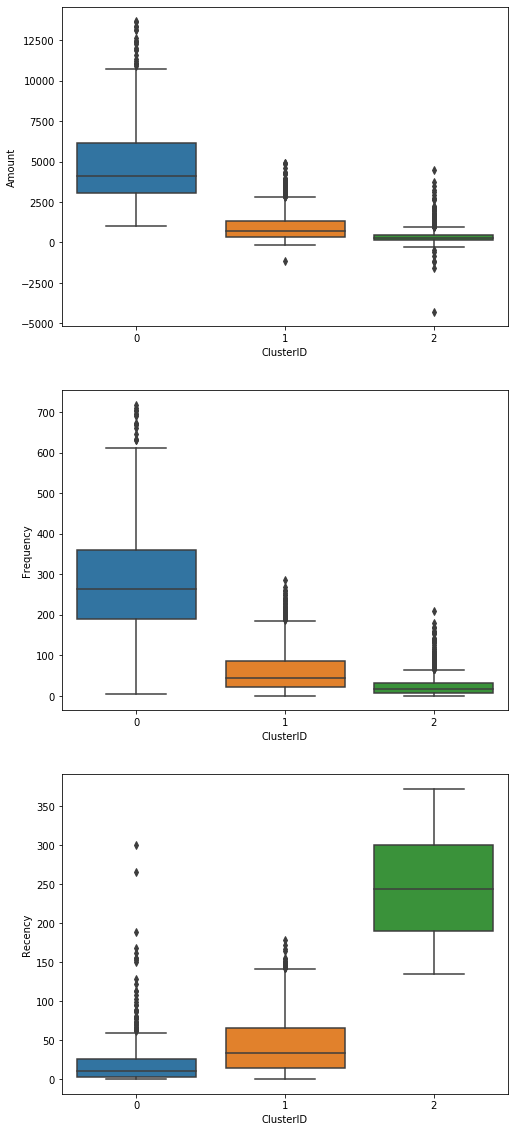

In [111]:
# plot

plt.figure(figsize=(8,20))
plt.subplot(3,1,1)
sns.boxplot(x='ClusterID', y='Amount', data = grouped_df)
plt.subplot(3,1,2)
sns.boxplot(x='ClusterID', y='Frequency', data = grouped_df)
plt.subplot(3,1,3)
sns.boxplot(x='ClusterID', y='Recency', data = grouped_df)